In [2]:
# Part 1: Basic use of Words2Vec
# Part 2: Sentiment Analysis using Words2Vec, Skipgram and CBoW models

In [ ]:
# Dataset used in part 2: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data

In [ ]:
#pip install gensim

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
# Load the pretrained Word2Vec model
model = api.load("word2vec-google-news-300")

## Part 1

### Similar words from Words2Vec

In [3]:
# Define a list of words
words = ["king", "lion", "man", "woman", "india"]

# Find and print similar words for each of the given words
for word in words:
    print(f"Similar words to '{word}':")
    similar_words = model.most_similar(word, topn=5)
    for similar_word, similarity in similar_words:
        print(f"  {similar_word}: {similarity:.4f}")
    print()

Similar words to 'king':
  kings: 0.7138
  queen: 0.6511
  monarch: 0.6413
  crown_prince: 0.6204
  prince: 0.6160

Similar words to 'lion':
  lions: 0.6357
  tiger: 0.5121
  elephant: 0.5120
  gorilla: 0.4892
  hyena: 0.4852

Similar words to 'man':
  woman: 0.7664
  boy: 0.6825
  teenager: 0.6587
  teenage_girl: 0.6148
  girl: 0.5922

Similar words to 'woman':
  man: 0.7664
  girl: 0.7495
  teenage_girl: 0.7337
  teenager: 0.6317
  lady: 0.6289

Similar words to 'india':
  indian: 0.6967
  usa: 0.6836
  pakistan: 0.6815
  chennai: 0.6676
  america: 0.6589



### Finding words based on relational analogies

In [4]:
analogies = [
    ("man", "woman", "brother"),  # Expected to be similar to "sister"
    ("king", "prince", "queen"),  # Expected to be similar to "palace"
    ("foot", "feet", "tooth")     # Expected to be similar to "teeth"
]

for a, b, c in analogies:
    try:
        result = model.most_similar(positive=[b, c], negative=[a], topn=1)
        print(f"{a} is to {b} as {c} is to: {result[0][0]}")
        print(f"similarity: {result[0][1]:.4f}")
    except KeyError as e:
        print(f"Error: {e}")
    print()

man is to woman as brother is to: sister
similarity: 0.8103

king is to prince as queen is to: princess
similarity: 0.7093

foot is to feet as tooth is to: teeth
similarity: 0.5431



## Part 2

In [5]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

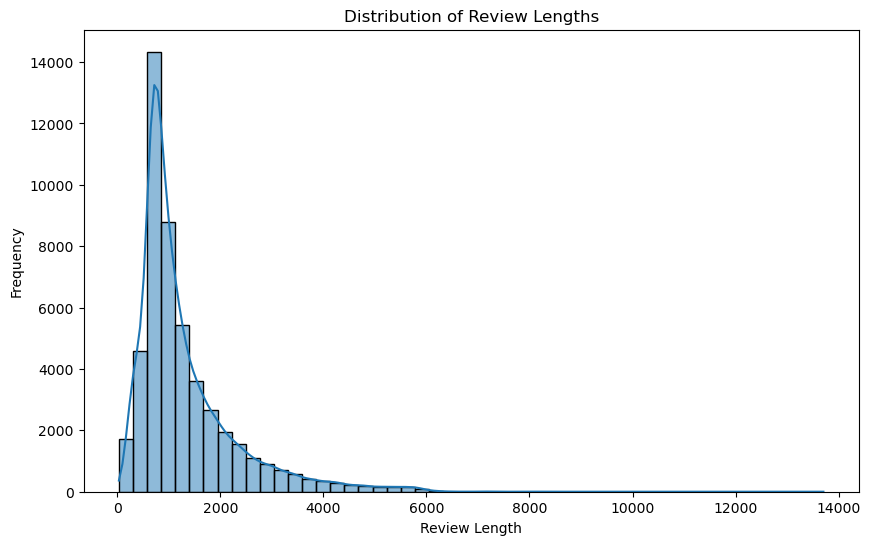

In [8]:
# Plot the distribution of review lengths
df['review_length'] = df['review'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

In [9]:
df['review_length'].describe()

count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_length, dtype: float64

In [10]:
# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove punctuation and lowercase the text
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_review'] = df['review'].apply(clean_text)

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [11]:
sentences = [review.split() for review in df['cleaned_review']]

### Skipgram and CBoW model

In [12]:
# Train a Skipgram model
skipgram = Word2Vec(
    sentences, 
    sg=1,
    vector_size=50,
    window=5,
    min_count=1,
)

# Train a CBOW model
cbow = Word2Vec(
    sentences, 
    sg=0,
    vector_size=50,
    window=5,
    min_count=1,
)

In [13]:
def get_average_vector(sentence, model):
    words = sentence.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

df['skipgram_vector'] = df['cleaned_review'].apply(lambda x: get_average_vector(x, skipgram))
df['cbow_vector'] = df['cleaned_review'].apply(lambda x: get_average_vector(x, cbow))

In [14]:
skipgram_X = np.array(df['skipgram_vector'].tolist())
cbow_X = np.array(df['cbow_vector'].tolist())

# Prepare labels (convert sentiment to binary)
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

skipgram_X_train, skipgram_X_test, y_train, y_test = train_test_split(skipgram_X, y, test_size=0.2, random_state=42)
cbow_X_train, cbow_X_test, _, _ = train_test_split(cbow_X, y, test_size=0.2, random_state=42)

def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return classification_report(y_test, y_pred)

print("Skip-gram Model:")
print(train_and_evaluate_model(skipgram_X_train, skipgram_X_test, y_train, y_test))

print("CBoW Model:")
print(train_and_evaluate_model(cbow_X_train, cbow_X_test, y_train, y_test))

Skip-gram Model:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      4961
           1       0.87      0.87      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

CBoW Model:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      4961
           1       0.84      0.86      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



### Pre-trained Words2Vec Model

In [15]:
def get_average_vector(sentence, model):
    words = sentence.split()
    vectors = [model[word] for word in words if word in model]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

df['pretrained_vector'] = df['cleaned_review'].apply(lambda x: get_average_vector(x, model))

In [16]:
pretrained_X = np.array(df['pretrained_vector'].tolist())
y = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

pretrained_X_train, pretrained_X_test, y_train, y_test = train_test_split(pretrained_X, y, test_size=0.2, random_state=42)

def train_and_evaluate_model(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return classification_report(y_test, y_pred)

print("Pretrained Word2Vec Model:")
print(train_and_evaluate_model(pretrained_X_train, pretrained_X_test, y_train, y_test))

Pretrained Word2Vec Model:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4961
           1       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

